**Session 10 : Advanced concepts - Training and Learning Rates**

***Assignemnt Objective: To implement LRFinder***

**LR Finder**
*Basic objective of LR finder is to find the highest LR which minimises the loss and doesnt make the loss explode or diverge. We can do this by traning a model while increasing the LR after evry batch, record the loss and finally use the LR just befor the loss exploded.*

Note: To run this notebook in colab
upload the add the google drive to the system path to access the tsai_repo


In [0]:
# !pip install albumentations
import sys
sys.path.append("/content/drive/My Drive/tsai/tsai_repo")

**IMPORTS**

In [2]:
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import torch
import torch.optim as optim

from data_loader.data_loader_cifar import dataLoader
from data_transformations.transform import AlbumentationTransforms
from models.resnet18 import ResNet18
from utils import denormalize
from training.training import train
from scoring.scoring import test
from scoring.accuracy import showMeasurePlots
from scoring.missclassified_images import identifyImages

import torch.nn as nn
from training.lrfinder import LRFinder

from gradcam.grad_cam import *

  pip install torch-lr-finder -v --global-option="amp"


**TRANSFORMS**

In this section we can define the alnumAlbumentationTransforms

In [0]:
#Transforms
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=4) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

**DATA LOADER**

We have loaded the data and plotted a few images

CUDA is available: True
Initiated Data Loader with: {'shuffle': True, 'batch_size': 128, 'num_workers': 4, 'pin_memory': True}


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: <data_transformations.transform.AlbumentationTransforms object at 0x7f87ba007940>
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
torch.Size([3, 32, 32])


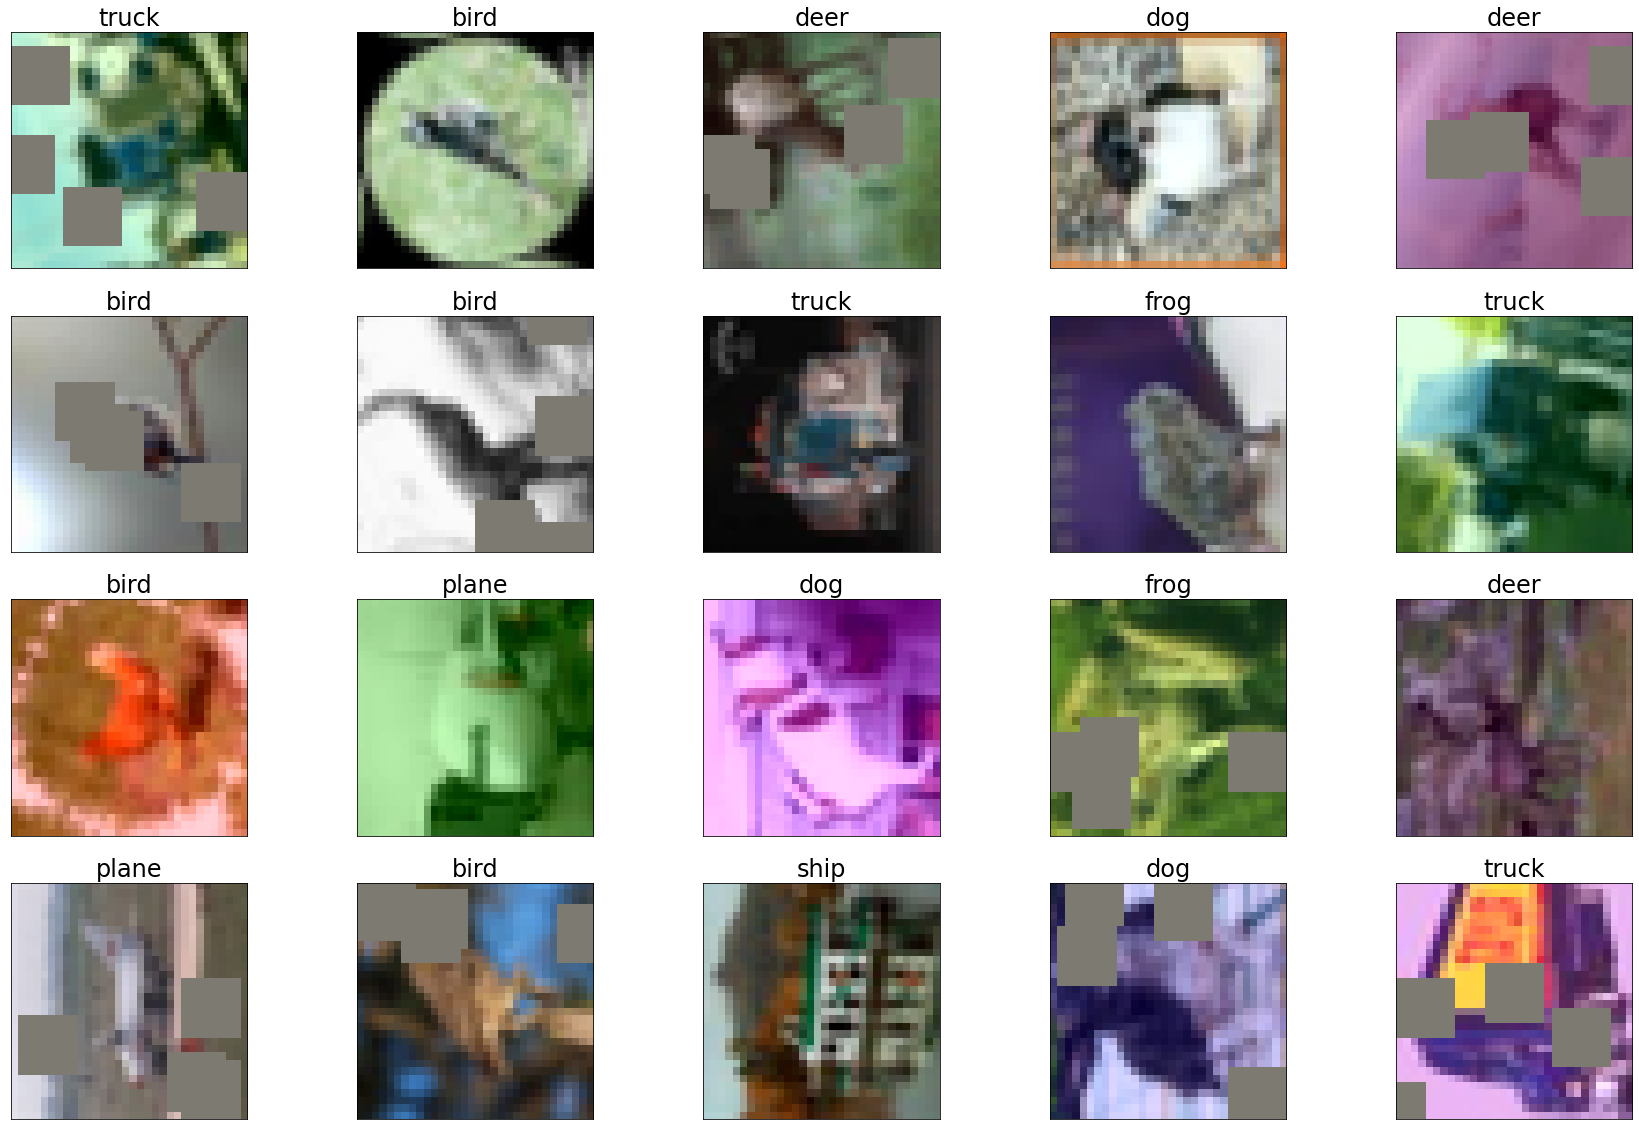

In [4]:
#Dataload
dataloader = dataLoader()
train_loader = dataloader.get_train_loader(train_transforms)
test_loader = dataloader.get_train_loader(test_transforms)
classes = dataloader.get_classes()
print(train_loader.dataset)
print(classes)

#Plot few images
dataiter = iter(train_loader)
images, target = next(dataiter)
print(images[0].shape)

#If the picture in sormalised then denormalise and plot it
fig = plt.figure(figsize=(30,20))
for i in range(0,20):
    plt_image = denormalize(images[i],channel_means,channel_stdevs)
    plt_image = np.transpose(plt_image,[2,1,0])
    plt_image = np.uint8(255*plt_image)
    plt.subplot(4,5,i+1)
    plt.imshow(plt_image)
    plt.title(str(classes[target[i]]),fontsize=24)
    plt.xticks([])
    plt.yticks([])
fig.show()

**MODEL LOADER**

In this section we are loading the resnet18 model


In [5]:
#Load the model
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

**EXECUTE**

1. run LR Finder to get the best LR
2. Set folowing paremters
  1. Number of epochs
  2. l1 and l2 regularization parameters
  3. best_lr = 0.05
3. Plot the accuracy Curves
4. Plot the Miss classified images
5. Run gradcam on misclassified images

**LR Finder**

1. Experiment 1: step mode as linear
2. Experiment 2: step model as exponential 


Learning rate search finished. See the graph with {finder_name}.plot()


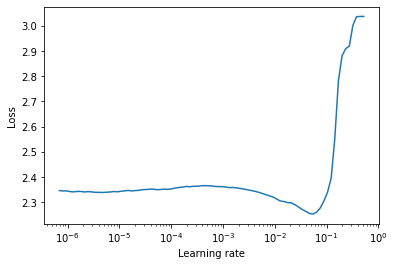

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-3)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader = train_loader,start_lr  = 1e-7, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot()


In [0]:
lr_finder.reset()

In [10]:
import plotly.express as px
lrs = lr_finder.history["lr"]
losses = lr_finder.history["loss"]
fig = px.line( x=lrs, y=losses, title='LR Finder Curve',log_x=True)
# fig.update_xaxes(range = [-1,max(lrs)])
# fig.update_yaxes(range = [0.5,0.9])
fig.show()

In [11]:
epochs = 10
L2lambda = 1e-3
L1lambda = 0
test_losses = []
train_losses = []
test_accuracy = []
train_accuracy = []
best_lr = 0.05

optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9,weight_decay=L2lambda)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min', 
                                           factor=0.1, # learning rate will be reduced by this factor 
                                           patience=10, # wait foe epochs to reduce
                                           verbose=True, #print the update 
                                           threshold=0.0001, 
                                           threshold_mode='rel', 
                                           cooldown=0, #wait till we can resumen the normal operation
                                           min_lr=0, 
                                           eps=1e-08)
for epoch in range(0, epochs):
    print("EPOCH:",epoch)
    train(model, device, train_loader, optimizer, train_losses, train_accuracy, L1lambda=0,scheduler=None)
    
    test(model, device, test_loader,test_losses,test_accuracy)
torch.save(model,"model_s10")

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.0501, Accuracy: 19210/50000 (38.4200%)

EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.9071, Accuracy: 27668/50000 (55.3360%)

EPOCH: 2


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.9766, Accuracy: 30908/50000 (61.8160%)

EPOCH: 3


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.0998, Accuracy: 33996/50000 (67.9920%)

EPOCH: 4


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.5662, Accuracy: 35030/50000 (70.0600%)

EPOCH: 5


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.6691, Accuracy: 38343/50000 (76.6860%)

EPOCH: 6


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.6337, Accuracy: 40016/50000 (80.0320%)

EPOCH: 7


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.0258, Accuracy: 39615/50000 (79.2300%)

EPOCH: 8


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.1044, Accuracy: 38654/50000 (77.3080%)

EPOCH: 9


loss=0.5310155153274536 batch_id=390: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]



Test set: Average loss: -5.9095, Accuracy: 41368/50000 (82.7360%)



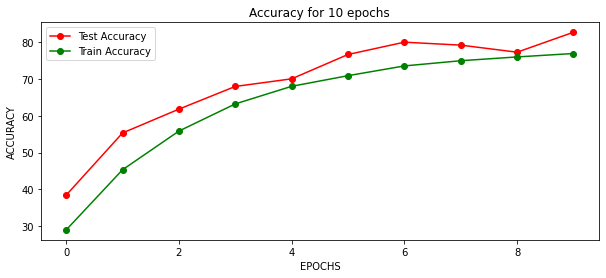

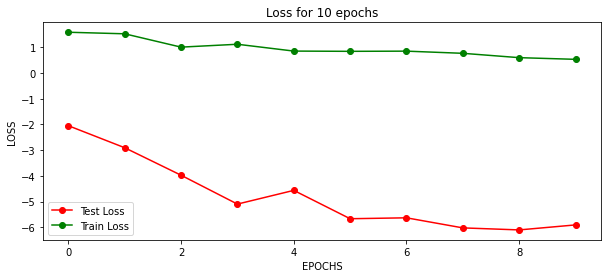

In [12]:
showMeasurePlots.plot_accuracy_curves(train_accuracy,test_accuracy,epochs)
showMeasurePlots.plot_loss_curves(train_losses,test_losses,epochs)

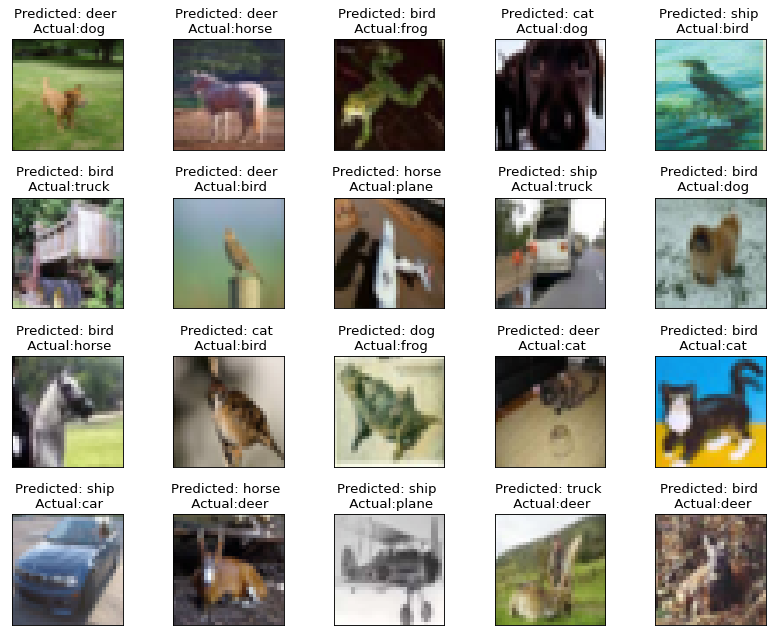

In [13]:
misclass_data_r, misclass_targets_r,misclass_pred_r = identifyImages.misclassified(model,test_loader,device)
from matplotlib.pyplot import figure
from utils import denormalize
fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
misclass_targets_r_cpu = misclass_targets_r.cpu().numpy()
misclass_pred_r_cpu = misclass_pred_r.cpu().numpy()
for num in range(0,20):
    plt.subplot(5,5,num+1)
    plt.tight_layout()
    mis_class_img = misclass_data_r[num]
    mis_class_img_cpu = mis_class_img.cpu()
    plt_image = denormalize(mis_class_img_cpu,channel_means,channel_stdevs)
    plt_image = np.transpose(plt_image, (1, 2, 0))
    plt_image = np.uint8(255*plt_image)
    plt.imshow(plt_image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted: {} \n Actual:{}".format(
    classes[misclass_pred_r_cpu[num]], classes[misclass_targets_r_cpu[num]]))


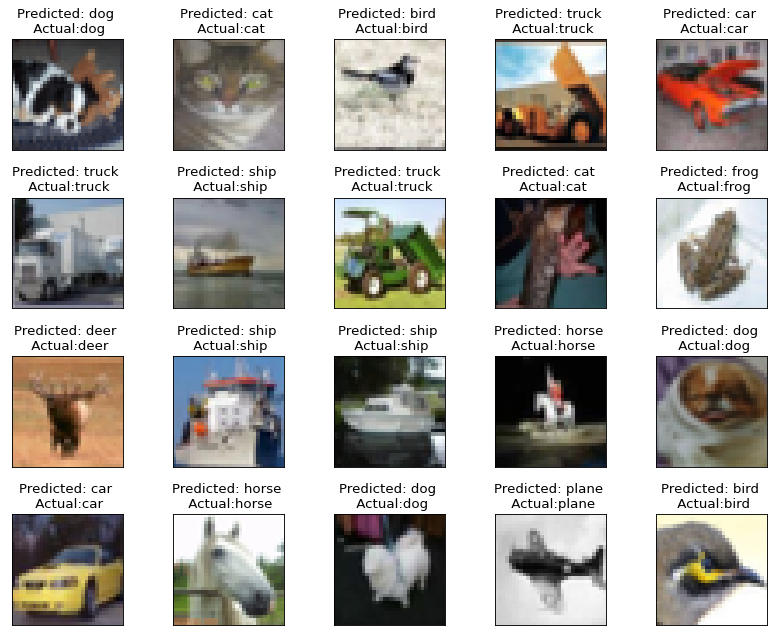

In [14]:
correctclass_data_r, correctclass_targets_r,correctclass_pred_r = identifyImages.correct_classified(model,test_loader,device)
from matplotlib.pyplot import figure
fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
correctclass_targets_r_cpu = correctclass_targets_r.cpu().numpy()
correctclass_pred_r_cpu = correctclass_pred_r.cpu().numpy()
for num in range(0,20):
    plt.subplot(5,5,num+1)
    plt.tight_layout()
    correct_class_img = correctclass_data_r[num]
    correct_class_img_cpu = correct_class_img.cpu()
    plt_image = denormalize(correct_class_img_cpu,channel_means,channel_stdevs)
    plt_image = np.transpose(plt_image, (1, 2, 0))
    plt_image = np.uint8(255*plt_image)
    plt.imshow(plt_image)
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted: {} \n Actual:{}".format(
    classes[correctclass_pred_r_cpu[num]], classes[correctclass_targets_r_cpu[num]]))


**GRADCAM**


Gradcam on 10 missclassified images

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


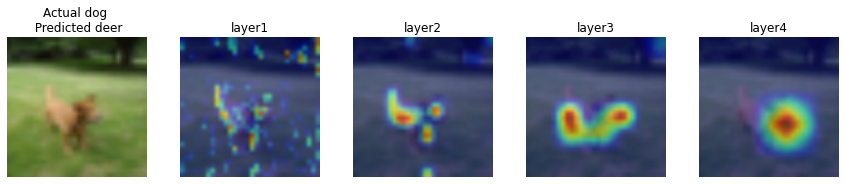

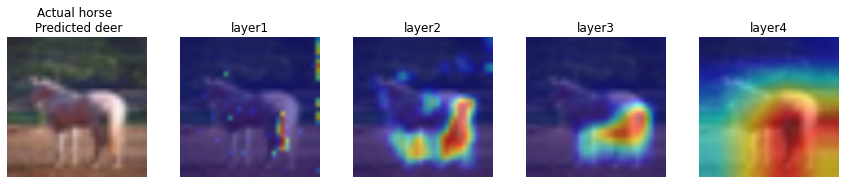

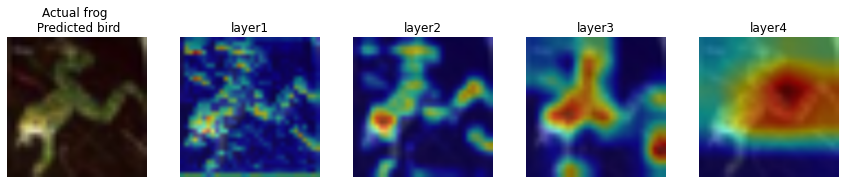

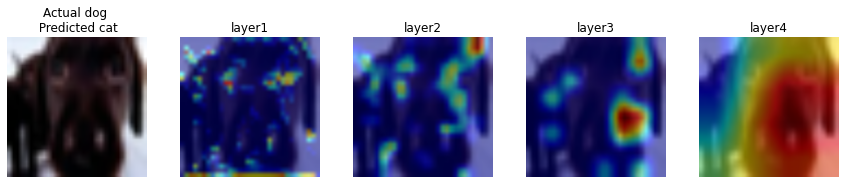

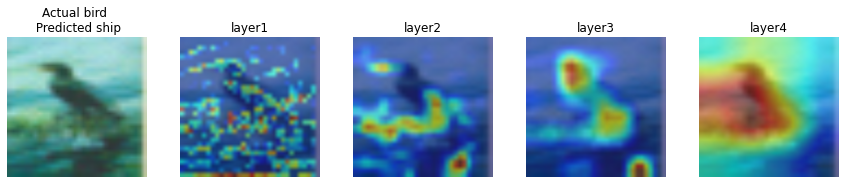

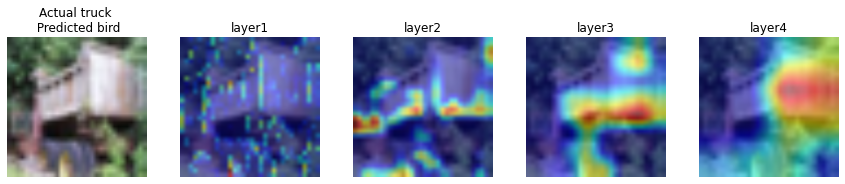

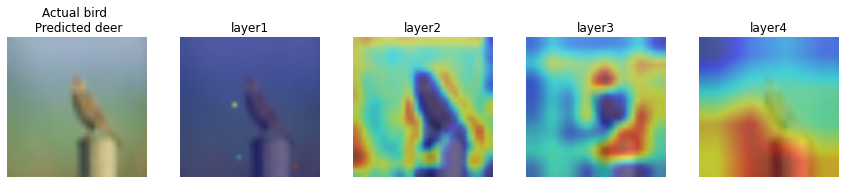

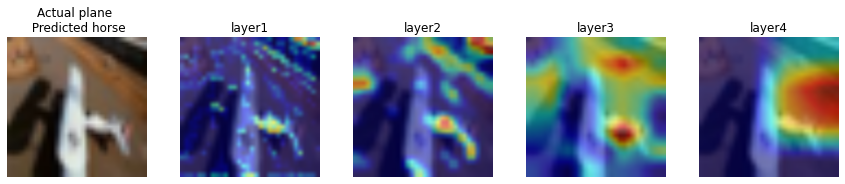

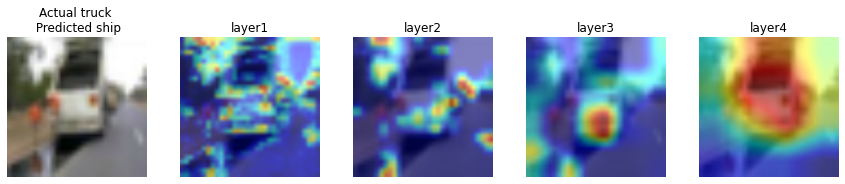

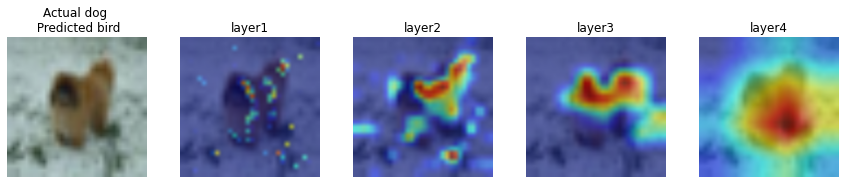

In [15]:
target_layers = ["layer1", "layer2","layer3", "layer4"]
images = misclass_data_r[0:10]
target_classes = misclass_targets_r[0:10]
gradcam_output, probs, predicted_classes = gradcam(images, target_classes, model, target_layers)
plot_gradcam_1(gradcam_output, images, target_classes, target_layers, classes, predicted_classes,channel_means,channel_stdevs)


Gradcam on 10 correctly classifed images

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


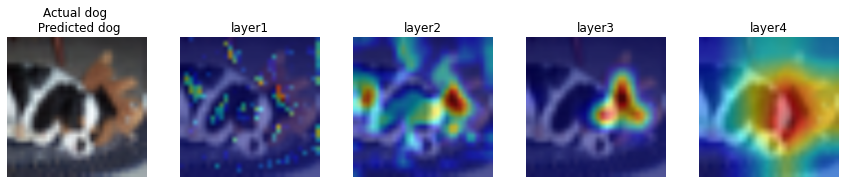

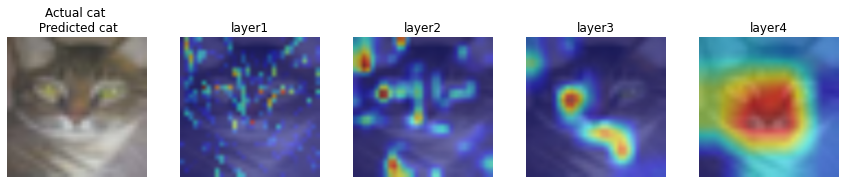

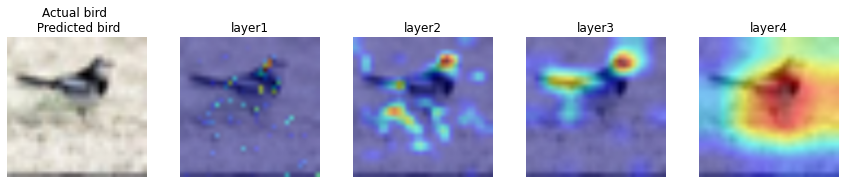

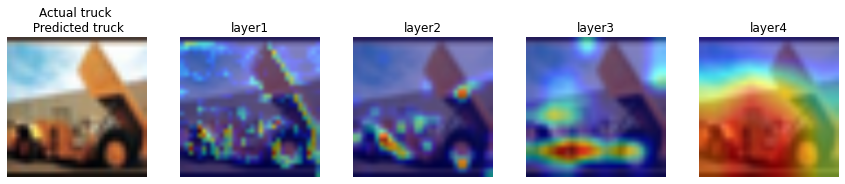

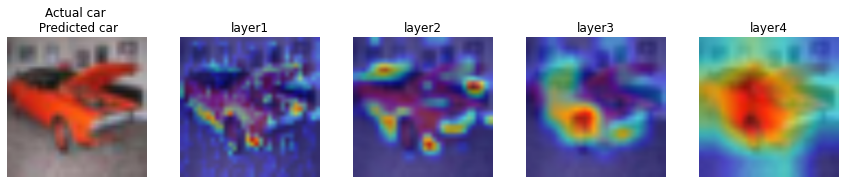

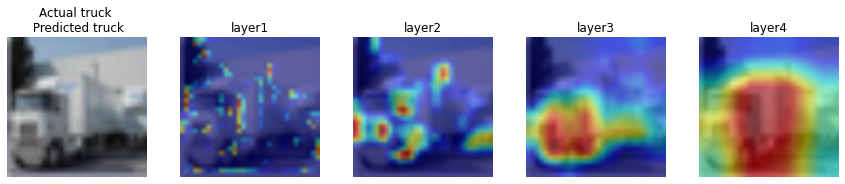

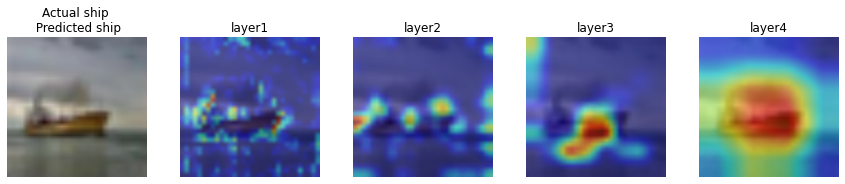

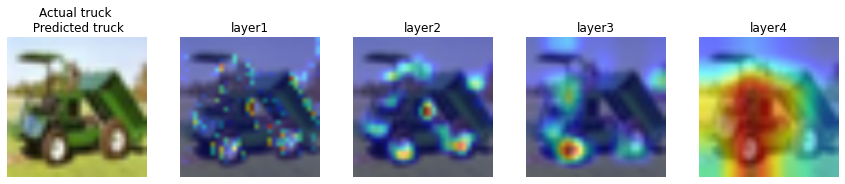

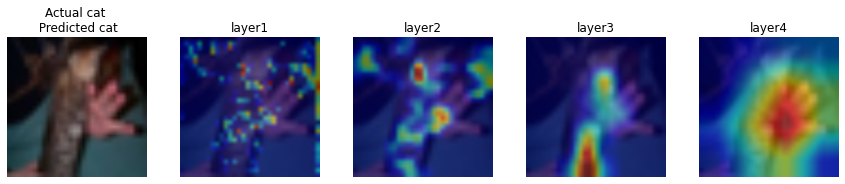

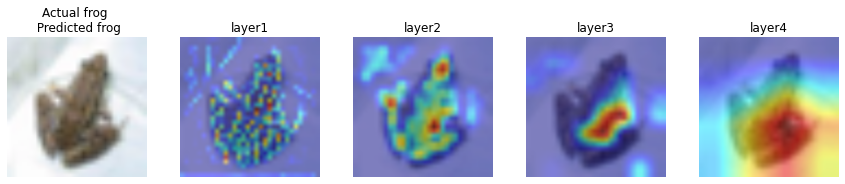

In [16]:
target_layers = ["layer1", "layer2","layer3", "layer4"]
images = correctclass_data_r[0:10]
target_classes = correctclass_targets_r[0:10]
gradcam_output, probs, predicted_classes = gradcam(images, target_classes, model, target_layers)
plot_gradcam_1(gradcam_output, images, target_classes, target_layers, classes, predicted_classes,channel_means,channel_stdevs)
